In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import math
from scipy import integrate
from numpy import diff
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amssymb}']}   # amssymb
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [3]:
# System of equations
def funciones(xi,y, alpha, n, h, Upsilon, varkappa):
    psi_ , eta_, psi1_, eta1_ = y
    dydxi = [-h*(eta_+ xi**(3)*(Upsilon*(psi_**(n+1) - varkappa**(1 + 1/n)) + alpha*(psi_**(n) - varkappa)))*(1 + Upsilon*(psi_ - (varkappa**(1 + 1/n)/psi_**(n))) + alpha*(1 - (varkappa/psi_**(n))))/xi/(xi - 2*Upsilon*(n+1)*eta_) /(1 + alpha*n/Upsilon/(n+1)/psi_) 
            ,xi**(2) * psi_**(n)
            ,-(h/xi/(xi - 2*Upsilon*(n+1)*eta_)/(1 + alpha*n/Upsilon/(n+1)/psi_))*((eta1_ + 3*xi**(2)*(Upsilon*(psi_**(n+1) - varkappa**(1 + 1/n)) + alpha*(psi_**(n) - varkappa)) + xi**(3)*(n+1)*Upsilon*psi_**(n)*psi1_*(1 + alpha*n/Upsilon/(n+1)/psi_))*(1 + Upsilon*(psi_ - varkappa**(1 + 1/n)/psi_**(n)) + alpha*(1 - varkappa/psi_**(n))) + (eta_ + xi**(3)*(Upsilon*(psi_**(n+1) - varkappa**(1+ 1/n)) + alpha*(psi_**(n) - varkappa)))*((n+1)*Upsilon*psi1_*(1 + alpha*n/Upsilon/(n+1)/psi_) - n*(Upsilon*(psi_**(n+1) - varkappa**(1 + 1/n)) + alpha*(psi_**(n) - varkappa))*psi1_/psi_**(n+1)) + (eta_ + xi**(3)*(Upsilon*(psi_**(n+1) - varkappa**(1 + 1/n)) + alpha*(psi_**(n) - varkappa)))*(1 + Upsilon*(psi_ - varkappa**(1 + 1/n)/psi_**(n)) + alpha*(1 - varkappa/psi_**(n)))*((2*Upsilon*(n+1)*eta1_ - 1)/(xi - 2*Upsilon*(n+1)*eta_) + alpha*n*psi1_/(1 + alpha*n/Upsilon/(n+1)/psi_)/Upsilon/(n+1)/psi_**(2) - 1/xi))
            ,2*xi*psi_**(n) + n*xi**(2)*psi_**(n-1)*psi1_] 
    return dydxi

In [4]:
c = 2.997*10**(8)               # Speed of light in SI units
G = 6.673*10**(-11)             # Gravitational Constant in SI units
Msun = 1.989*10**(30)           # 1 Solar Mass in SI units

In [5]:
                                               ## List of parameters ##

n = 4.0
print('n: ',n)

varkappa = 0.05
print('\u03f0:',varkappa)
   
Lista_alpha = [-0.1,-0.05,0.000001,0.05,0.099999]
print('\u03b1 interval: ',end='')
print(*Lista_alpha, sep=', ')


# Lista_C = [-1/4,-7/32,-3/16,-5/32,-1/8,-3/32,-1/16,-1/32,0]   # Negativos
Lista_C = [0,1/32,1/16,3/32,1/8,5/32,3/16,7/32,1/4]     # Positivos
print('C interval: ',end='')
print(*Lista_C, sep=', ')


Lista_sigma = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
print('\u03c3 interval: ',end='')
print(*Lista_sigma, sep=', ')

Number_of_models = len(Lista_alpha)*len(Lista_C)*len(Lista_sigma)
print('Number of models: ', Number_of_models)

rho_c = 2.5*10**(18)

n:  4.0
ϰ: 0.05
α interval: -0.1, -0.05, 1e-06, 0.05, 0.099999
C interval: 0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25
σ interval: 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8
Number of models:  720


In [6]:
ListaModelos = []                                        # Container for all models 

for i in range(len(Lista_alpha)):
    
    ListaModelos.append([])                              # Container for n
    
    for j in range(len(Lista_C)):
        
        ListaModelos[i].append([])                       # Container for C
        
        for k in range(len(Lista_sigma)):
            
            ListaModelos[i][j].append([])                # Contenedor para sigma

In [7]:
%%time

contador = 0

for i in range(len(Lista_alpha)):
    
    alpha = Lista_alpha[i]
    
    for j in range(len(Lista_C)):
        
        C = Lista_C[j]
        h = 1 - 2*C
        
        for k in range(len(Lista_sigma)):
            
            sigma = Lista_sigma[k]
        
            Upsilon = (sigma - alpha*(1 - varkappa))/(1 - varkappa**(1 + 1/n))
            
            K = Upsilon*c**(2)/rho_c**(1/n)      # k**(n) en m**(3)/kg
                     
            # Condiciones iniciales
            Psi0 = 1.0
            Eta0 = 0.0
            Psi10 = 0.0
            Eta10 = 0.0
            
            y0 = [Psi0,Eta0,Psi10,Eta10]
            
            def stop_condition(xi,y,alpha, n, h, Upsilon, varkappa):
                return (1/sigma)*(Upsilon*(y[0]**(n+1) - varkappa**(1 + 1/n)) + alpha*(y[0]**(n) - varkappa)) - 10**-15
                    
            stop_condition.terminal = True
            
            xi0 = 10**(-15)
            ximax = 10000
    
            xi_span = (xi0,ximax)
        
            soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                                           args=(alpha, n, h, Upsilon, varkappa))
            
            if soluciones.status == 0:
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                ListaModelos[i][j][k].append(1)
                print('Insufficient integration interval xi, please increase it. Parameters: ',
                      'C = %.3f, '%(C),'n = %.1f, '%(n),'\u03c3 = %.2f, '%(sigma), '\u03f0 = %.2f, '%(varkappa),
                     '\u03b1 = %.2f, '%(alpha))
                contador = contador + 1
                continue
            
            Psi = soluciones.y[0]
            Eta = soluciones.y[1]
            Psi1 = soluciones.y[2]
            Eta1 = soluciones.y[3]
            xi = soluciones.t 
            
            #########################################################################################################
            
            xiNorm = xi/xi[-1]                                       # xi normalized
            
            Densidad = Psi**(n)                                      # Density
            
            varP = Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)
            
            Dprima = n*Psi**(n-1)*Psi1                               # Density gradient
            
            # Pressure divided by central pressure
            PNorm = (1/sigma)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa))
            
            m = (c**(2)*Upsilon*(n+1)/(4*np.pi*rho_c)**(1/3)/G)**(3/2)*Eta/Msun    # Mass in solar mass unit
            r = (c**(2)*Upsilon*(n+1)/4/np.pi/G/rho_c)**(1/2)*xi/1000              # Radius in kilometers
            mr = 2*Upsilon*(n+1)*Eta/xi                                            # 2*G*m/c**(2)/r
            
            # Tangential pressure
            PTNorm = C*Upsilon*(n+1)*(Eta + xi**(3)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))*(Psi**(n) + (Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))/sigma/(xi - 2*Upsilon*(n+1)*Eta) + (Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa))/sigma
            
            # Second derivative of Psi
            Psi11 = -(h/xi/(xi - 2*Upsilon*(n+1)*Eta)/(1 + alpha*n/Upsilon/(n+1)/Psi))*((Eta1 + 3*xi**(2)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)) + xi**(3)*(n+1)*Upsilon*Psi**(n)*Psi1*(1 + alpha*n/Upsilon/(n+1)/Psi))*(1 + Upsilon*(Psi - varkappa**(1 + 1/n)/Psi**(n)) + alpha*(1 - varkappa/Psi**(n))) + (Eta + xi**(3)*(Upsilon*(Psi**(n+1) - varkappa**(1+ 1/n)) + alpha*(Psi**(n) - varkappa)))*((n+1)*Upsilon*Psi1*(1 + alpha*n/Upsilon/(n+1)/Psi) - n*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa))*Psi1/Psi**(n+1)) + (Eta + xi**(3)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))*(1 + Upsilon*(Psi - varkappa**(1 + 1/n)/Psi**(n)) + alpha*(1 - varkappa/Psi**(n)))*((2*Upsilon*(n+1)*Eta1 - 1)/(xi - 2*Upsilon*(n+1)*Eta) + alpha*n*Psi1/(1 + alpha*n/Upsilon/(n+1)/Psi)/Upsilon/(n+1)/Psi**(2) - 1/xi))
            
            mrprima = Upsilon*(n+1)*(Eta1/xi - Eta/xi**(2))           # Derivative of  m/r
            
            Pprima = (1/sigma)*Upsilon*(n+1)*Psi**(n)*Psi1*(1 + alpha*n/(n+1)/Upsilon/Psi)    # Radial pressure gradient
            # Tangential pressure gradient
            Ptprima = (1/sigma)*(C*Upsilon*(n+1)*(((Eta1 + 3*xi**(2)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)) + xi**(3)*Upsilon*(n+1)*Psi**(n)*Psi1*(1 + alpha*n/Upsilon/(n+1)/Psi))*(Psi**(n) + Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)) + (Eta + xi**(3)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))*(n*Psi**(n-1)*Psi1 + Upsilon*(n+1)*Psi**(n)*Psi1*(1 + alpha*n/Upsilon/(n+1)/Psi)))/(xi - 2*Upsilon*(n+1)*Eta) - (Eta + xi**(3)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))*(Psi**(n) + Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa))*(1 - 2*Upsilon*(n+1)*Eta1)/(xi - 2*Upsilon*(n+1)*Eta)**(2)) + Upsilon*(n+1)*Psi**(n)*Psi1*(1 + alpha*n/Upsilon/(n+1)/Psi))
            
            SEC = (1/sigma)*Densidad - PNorm - 2*PTNorm               # Strong energy condition (SEC) 
            
           # Velocidad del sonido radial al cuadrado
            v2r = Upsilon*(1 + 1/n)*Psi + alpha # Velocidad del sonido al cuadrado
    
            # Diferencia de las velocidades del sonido al cuadrado
            vDelta2 = (C*Upsilon*(n+1)/(xi - 2*Upsilon*(n+1)*Eta))*((1 + Upsilon*(n+1)*Psi/n + alpha)*(Eta + xi**(3)*varP) + (Psi**(n) + varP)*xi**(2)*Psi*((Psi**(n) + 3*varP)/n/Psi**(n)/Psi1 + (xi/Psi)*((Upsilon*(n+1)*Psi)/n + alpha)) - Psi*(Psi**(n) + varP)*(Eta + xi**(3)*varP)*(1 - 2*Upsilon*(n+1)*xi**(2)*Psi**(n))/(n*Psi**(n)*Psi1*(xi - 2*Upsilon*(n+1)*Eta)))
    
            # Velocidad del sonido tangencial al cuadrado
            v2t = vDelta2 + v2r
            Gamma = v2r*(Densidad + sigma*PNorm)/PNorm/sigma          # Adiabatic index Gamma
            
            # Cracking: deltaR1: Density, deltaR2: Mass, deltaR3: Pressure, delta R4: Pressure gradient   
            deltaR1 = h*Upsilon*(n+1)*(Eta + xi**(3)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))/xi/(xi - 2*Upsilon*(n+1)*Eta)
            deltaR2 = h*Upsilon*(n+1)*xi**(2)*Psi*(Psi**(n) + (Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa)))*(1 + 2*Upsilon*(n+1)*(Upsilon*(Psi**(n+1) - varkappa**(1 + 1/n)) + alpha*(Psi**(n) - varkappa))*xi**(2))/n/Psi1/(xi - 2*Upsilon*(n+1)*Eta)**(2)
            deltaR3 = h*Upsilon*(n+1)*(Eta + xi**(3)*(Psi**(n) + 2*(Upsilon*(Psi**(n+1) - varkappa**(1+1/n)) + alpha*(Psi**(n) - varkappa))))*(Upsilon*(n+1)*Psi/n + alpha)/(xi*(xi - 2*Upsilon*(n+1)*Eta))
            deltaR4 = Upsilon*(n+1)*(n*Psi1**(2) + Psi*Psi11)/n/Psi1 + alpha*((n-1)*Psi1**(2) + Psi*Psi11)/Psi/Psi1
            deltaRMaster = deltaR1 + deltaR2 + deltaR3 + deltaR4
            
            # Buoyancy
            Psin11 = n*(Psi**(n-1)*Psi11 + (n-1)*Psi**(n-2)*Psi1**(2))
            
            M = (c**(2)*(n+1)/(4*np.pi)**(1/3)/G)**(3/2)*(k/c**(2))**(n/2)*Upsilon**((3-n)/2)*Eta[-1]/Msun  # Mass in solar mass unit
            
            R = (c**(2)*(n+1)/4/np.pi/G)**(1/2)*(k/c**(2))**(n/2)*Upsilon**((1-n)/2)*xi[-1]/1000            # Radius in kilometers
            
            ##########################################################################################################
            
            # Conditions C1a, C1b and C1c
            
            if any(mr >= 1):
                ListaModelos[i][j][k].append(1)
            else:
                pass
            
            # Condition C2
            
            if any(Densidad < 0) or any(PNorm < 0) or any(PTNorm < 0):
                ListaModelos[i][j][k].append(1)
            else:
                pass
            
            # Condition C3
            
            if any(Dprima > 0) or any (Pprima > 0) or any (Ptprima[20:] > 0):
                ListaModelos[i][j][k].append(1)
            else:
                pass
            

            # Condition C4
            
            if any(SEC < 0):
                ListaModelos[i][j][k].append(1)
            else:
                pass
            
            # Condition C5
            
            if any(Gamma < 4/3):
                ListaModelos[i][j][k].append(1)
            else:
                pass
            
            # Condition C6
            
            if any(v2r > 1) or any(v2t > 1):
                ListaModelos[i][j][k].append(1)
            else:
                pass
            
###############################################################################            
            
            if varkappa == 0.05 :
                
                if n == 0.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 or alpha == 0.05 : pass
                        
                        elif alpha == 0.099999 and (sigma < 0.3 or sigma > 0.6 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 or alpha == 0.05 : pass
                        
                        elif alpha == 0.099999 and (sigma < 0.35 or sigma > 0.45 ) : ListaModelos[i][j][k].append(1)
                        
                        else : pass
                                
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 : pass
                        
                        elif alpha == 0.05 and sigma > 0.775 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                    
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 : pass
                        
                        elif alpha == 0.05 and sigma > 0.675 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 or alpha == -0.05 : pass
                        
                        elif alpha == 0.000001 and sigma > 0.775 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.6 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 : pass
                        
                        elif alpha == -0.05 and sigma > 0.8 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.675 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.5 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.775 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.7 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.6 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.675 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.6 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.5 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and (sigma < 0.1 or sigma > 0.35 ) : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.575 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.5 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and (sigma < 0.1 or sigma > 0.25) : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                    
                    else : pass
                        
                elif n == 1.0 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.625 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.525 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.4 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.575 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.475 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.55 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.45 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.325 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.5 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.45 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.375 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.375 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.325 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 1.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.375 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.325 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 2.0 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 2.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                            
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                    
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                            
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                            
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 3.0 :
                
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                            
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                    
                elif n == 3.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 4.0 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                
                else : pass           
            
            elif varkappa == 0.2:
                
                if n == 0.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 or alpha == 0.05 : pass
                        
                        elif alpha == 0.099999 and sigma < 0.1 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 or alpha == 0.05 : pass
                        
                        elif alpha == 0.099999 and (sigma < 0.1 or sigma > 0.775 ) : ListaModelos[i][j][k].append(1)
                        
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 or alpha == -0.05 or alpha == 0.000001 : pass
                        
                        elif alpha == 0.05 and sigma > 0.825 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 and (sigma < 0.1 or sigma > 0.675 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 or alpha == -0.05 : pass
                        
                        elif alpha == 0.000001 and sigma > 0.85 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.75 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 and (sigma < 0.125 or sigma > 0.6 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 or alpha == -0.05 : pass
                        
                        elif alpha == 0.000001 and sigma > 0.775 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.65 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 and (sigma < 0.125 or sigma > 0.525 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.85 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.75 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.675 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.575 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 and (sigma < 0.125 or sigma > 0.425 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.725 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.675 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.575 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.475 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 and (sigma < 0.125 or sigma > 0.35 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.625 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.575 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.5 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.4 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 and (sigma < 0.15 or sigma > 0.25 ) : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.55 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.475 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.325 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 1.0 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.525 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.45 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.375 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.525 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.475 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.4 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.325 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.425 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.375 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.4 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.375 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.325 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.35 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 1.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.3 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.275 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.25 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.225 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 2.0 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.2 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.175 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 2.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.15 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.125 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 3.0 :
                
                    if C == 0.0 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 and sigma > 0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                    
                elif n == 3.5 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                        
                elif n == 4.0 :
                    
                    if C == 0.0 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.03125 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                            
                    elif C == 0.0625 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.09375 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.125 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.15625 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.1875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.21875 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    elif C == 0.25 :
                        
                        if alpha == -0.1 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == -0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.000001 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.05 : ListaModelos[i][j][k].append(1)
                        
                        elif alpha == 0.099999 : ListaModelos[i][j][k].append(1)
                            
                        else : pass
                        
                    else : pass
                
                else : pass
                
            else : pass
            
#######################################################################################################
            
               
            # Condition C8
           
            if any(np.diff(np.sign(deltaRMaster[1:])) != 0):
                ListaModelos[i][j][k].append(1)
            else:
                pass

            # Condition C9
            
            if any(Psin11 > 0):
                ListaModelos[i][j][k].append(1)
            else:
                pass   
            
            
                
                

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in subtract
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in add
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in greater
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in add


Wall time: 3.78 s


In [8]:
print(contador, ' out of ', Number_of_models, ' are NOT integrable')

0  out of  720  are NOT integrable


In [9]:
alpha_List0 = []
C_List0 = []
sigma_List0 = []

alpha_List1 = []
C_List1 = []
sigma_List1 = []

alpha_List2 = []
C_List2 = []
sigma_List2 = []

alpha_List3 = []
C_List3 = []
sigma_List3 = []

alpha_List4 = []
C_List4 = []
sigma_List4 = []

alpha_List7 = []
C_List7 = []
sigma_List7 = []

con1 = 0
con2 = 0
con3 = 0
con4 = 0
con5 = 0


for i in range(len(Lista_alpha)):
    
    for j in range(len(Lista_C)):
        
        for k in range(len(Lista_sigma)):
            
            if len(ListaModelos[i][j][k]) == 0:
                
                alpha_List0.append(Lista_alpha[i])
                C_List0.append(Lista_C[j])
                sigma_List0.append(Lista_sigma[k])
                
            elif len(ListaModelos[i][j][k]) == 1:
                
                alpha_List1.append(Lista_alpha[i])
                C_List1.append(Lista_C[j])
                sigma_List1.append(Lista_sigma[k])
            
            elif len(ListaModelos[i][j][k]) == 2:
                
                alpha_List2.append(Lista_alpha[i])
                C_List2.append(Lista_C[j])
                sigma_List2.append(Lista_sigma[k])
            
            elif len(ListaModelos[i][j][k]) == 3:
                
                alpha_List3.append(Lista_alpha[i])
                C_List3.append(Lista_C[j])
                sigma_List3.append(Lista_sigma[k])
            
            elif len(ListaModelos[i][j][k]) == 4:
                
                alpha_List4.append(Lista_alpha[i])
                C_List4.append(Lista_C[j])
                sigma_List4.append(Lista_sigma[k])
            
            elif len(ListaModelos[i][j][k]) == 10:
                
                alpha_List7.append(Lista_alpha[i])
                C_List7.append(Lista_C[j])
                sigma_List7.append(Lista_sigma[k])
                                   
            else:
                pass

In [10]:
legend_elements = [Line2D([0],[0],marker='o',color='w',label='9',markerfacecolor='red',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='8',markerfacecolor='blue',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='7',markerfacecolor='green',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='6',markerfacecolor='darkorange',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='5',markerfacecolor='purple',markersize=5)]

4.0


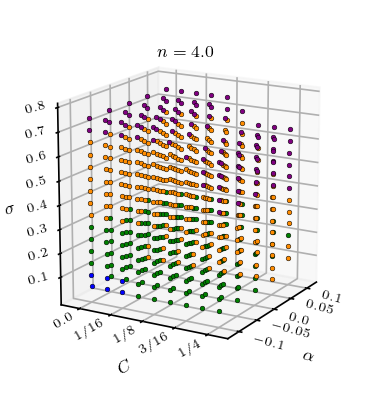

In [11]:
fig = plt.figure(figsize=(6,9),dpi=150)
# fig.suptitle(r'$\varkappa = {}$'.format(varkappa),x=0.31,y=0.86,fontsize=8,zorder=7)
fig.suptitle(r'$n = {}$'.format(n),x=0.31,y=0.86,fontsize=8,zorder=7)
print(n)


ax00 = fig.add_subplot(321, projection='3d',zorder=3)
# ax00.scatter(alpha_List0,C_List0,sigma_List0,c='red',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(alpha_List1,C_List1,sigma_List1,c='blue',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(alpha_List2,C_List2,sigma_List2,c='green',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(alpha_List3,C_List3,sigma_List3,c='darkorange',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)
ax00.scatter(alpha_List4,C_List4,sigma_List4,c='purple',marker='o',s=5,depthshade=False,edgecolors='k',linewidths=0.25)

ax00.xaxis.set_rotate_label(False)
ax00.yaxis.set_rotate_label(False)
ax00.zaxis.set_rotate_label(False)
ax00.set_xlabel(r'$\alpha$',fontsize=8,labelpad=-3.0,rotation=-15)
ax00.set_ylabel(r'$C$',fontsize=8,labelpad=-5.5,rotation=30)
ax00.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax00.set_xticks([-0.1,-0.05,0.0,0.05,0.1])
ax00.set_yticks([0,1/16,1/8,3/16,1/4])
ax00.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6])#,0.7,0.8])
ax00.grid(b=True,)
ax00.set_xbound(-0.125,0.125)
ax00.set_ybound(-1/32,9/32)
ax00.set_zbound(0.0,0.85)
ax00.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax00.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax00.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax00.set_xticklabels([r'$-0.1$',r'$-0.05$',r'$0.0$',r'$0.05$',r'$0.1$'],ha='left',va='bottom',fontsize=6)
ax00.set_yticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='right',va='baseline',fontsize=6)
# ax00.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
# ax00.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$'],ha='left',va='baseline',fontsize=6)
ax00.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax00.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline',fontsize=6)
ax00.view_init(elev=-165, azim=150)
ax00.invert_xaxis()
ax00.invert_yaxis()
ax00.invert_zaxis()
ax00.set_zbound(0.0,0.8)

# Legend = ax00.legend(handles=legend_elements,title=r'$N\acute{u}mero\ de\ condiciones\ cumplidas$',
#                      ncol=5,loc=(0.03,0.95),fontsize=6)
# plt.setp(Legend.get_title(),fontsize='small')


fig.subplots_adjust(wspace=0.075,hspace=-0.1)
plt.show()

In [12]:
fig = plt.figure(figsize=(6,9),dpi=150)
fig.suptitle(r'$n = {}$'.format(n),x=0.5125,y=0.85,fontsize=10,zorder=7)

ax00 = fig.add_subplot(321, projection='3d',zorder=6)
ax01 = fig.add_subplot(322, projection='3d',zorder=5)
ax10 = fig.add_subplot(323, projection='3d',zorder=4)
ax11 = fig.add_subplot(324, projection='3d',zorder=3)


ax00.scatter(alpha_List0,C_List0,sigma_List0,c='red',marker='o',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax01.scatter(alpha_List1,C_List1,sigma_List1,c='blue',marker='s',s=5.0,depthshade=False,edgecolors='k',linewidths=0.25)
ax10.scatter(alpha_List2,C_List2,sigma_List2,c='green',marker='d',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)

ax11.scatter(alpha_List0,C_List0,sigma_List0,c='red',marker='o',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax11.scatter(alpha_List1,C_List1,sigma_List1,c='blue',marker='s',s=5.0,depthshade=False,edgecolors='k',linewidths=0.25)
ax11.scatter(alpha_List2,C_List2,sigma_List2,c='green',marker='d',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax11.scatter(alpha_List3,C_List3,sigma_List3,c='darkorange',marker='^',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)
ax11.scatter(alpha_List4,C_List4,sigma_List4,c='purple',marker='*',s=7.5,depthshade=False,edgecolors='k',linewidths=0.25)

ax00.xaxis.set_rotate_label(False)
ax00.yaxis.set_rotate_label(False)
ax00.zaxis.set_rotate_label(False)
ax00.set_xlabel(r'$\alpha$',fontsize=8,labelpad=-3.0,rotation=-15)
ax00.set_ylabel(r'$C$',fontsize=8,labelpad=-5.5,rotation=30)
ax00.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
# ax00.set_xticks([-0.1,-0.05,0.0,0.05,0.1])
ax00.set_xticks([-0.1,-0.05,0.0,0.05])
ax00.set_yticks([0,1/16,1/8,3/16,1/4])
ax00.set_zticks([0.1,0.2,0.3])
ax00.grid(b=1)
ax00.set_xbound(-0.125,0.075)
ax00.set_ybound(-1/32,9/32)
ax00.set_zbound(0.0,0.35)
ax00.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax00.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax00.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax00.set_xticklabels([r'$-0.1$',r'$-0.05$'],ha='left',va='bottom')
ax00.set_yticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='right',va='baseline')
ax00.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$'],ha='left',va='baseline')
ax00.view_init(elev=-165, azim=150)
ax00.invert_xaxis()
ax00.invert_yaxis()
ax00.invert_zaxis()

ax01.xaxis.set_rotate_label(False)
ax01.yaxis.set_rotate_label(False)
ax01.zaxis.set_rotate_label(False)
ax01.set_xlabel(r'$\alpha$',fontsize=8,labelpad=-3.0,rotation=-15)
ax01.set_ylabel(r'$C$',fontsize=8,labelpad=-5.5,rotation=30)
ax01.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax01.set_xticks([-0.1,-0.05,0.0])
ax01.set_yticks([0,1/16,1/8,3/16,1/4])
ax01.set_zticks([0.1,0.2,0.3,0.4,0.5])
ax01.grid(b=True,)
ax01.set_xbound(-0.125,0.025)
ax01.set_ybound(-1/32,9/32)
ax01.set_zbound(0.05,0.5)
ax01.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax01.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax01.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax01.set_xticklabels([r'$-0.1$',r'$-0.05$',r'$0.0$'],ha='left',va='bottom')
ax01.set_yticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='right',va='baseline')
ax01.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$'],ha='left',va='baseline')
ax01.view_init(elev=-165, azim=150)
ax01.invert_xaxis()
ax01.invert_yaxis()
ax01.invert_zaxis()


ax10.xaxis.set_rotate_label(False)
ax10.yaxis.set_rotate_label(False)
ax10.zaxis.set_rotate_label(False)
ax10.set_xlabel(r'$\alpha$',fontsize=8,labelpad=-3.0,rotation=-15)
ax10.set_ylabel(r'$C$',fontsize=8,labelpad=-5.5,rotation=30)
ax10.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax10.set_xticks([-0.1,-0.05,0.0,0.05,0.1])
ax10.set_yticks([0,1/16,1/8,3/16,1/4])
ax10.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax10.grid(b=True,)
ax10.set_xbound(1.25*min(Lista_alpha),1.25*max(Lista_alpha))
ax10.set_ybound(-1/32,9/32)
ax10.set_zbound(0.05,0.6)
ax10.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax10.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax10.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax10.set_xticklabels([r'$-0.1$',r'$-0.05$',r'$0.0$',r'$0.05$',r'$0.1$'],ha='left',va='bottom')
ax10.set_yticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='right',va='baseline')
ax10.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$'],ha='left',va='baseline')
ax10.view_init(elev=-165, azim=150)
ax10.invert_xaxis()
ax10.invert_yaxis()
ax10.invert_zaxis()


ax11.xaxis.set_rotate_label(False)
ax11.yaxis.set_rotate_label(False)
ax11.zaxis.set_rotate_label(False)
ax11.set_xlabel(r'$\alpha$',fontsize=8,labelpad=-3.0,rotation=-15)
ax11.set_ylabel(r'$C$',fontsize=8,labelpad=-5.5,rotation=30)
ax11.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax11.set_xticks([-0.1,-0.05,0.0,0.05,0.1])
ax11.set_yticks([0,1/16,1/8,3/16,1/4])
ax11.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax11.grid(b=True,)
ax11.set_xbound(-0.125,0.125)
ax11.set_ybound(-1/32,9/32)
ax11.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax11.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax11.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax11.set_xticklabels([r'$-0.1$',r'$-0.05$',r'$0.0$',r'$0.05$',r'$0.1$'],ha='left',va='bottom')
ax11.set_yticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='right',va='baseline')
ax11.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$'],ha='left',va='baseline')
ax11.view_init(elev=-165, azim=150)
ax11.set_zbound(0.0,0.65)

ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.invert_zaxis()

Legend = ax00.legend(handles=legend_elements,title='Number of conditions fulfilled',ncol=5,loc=(0.385,0.95),fontsize=8)
plt.setp(Legend.get_title(),fontsize='medium')


fig.subplots_adjust(wspace=0.075,hspace=-0.1)
plt.show()

ValueError: 'vertices' must be a 2D list or array with shape Nx2